"flowchart" per l'applicazione.

1. lettura e preprocessing dei dati
2. lavorazione sul modello
3. generazione output 
4. valutazione output

In [3]:
# packages
import pandas as pd
import numpy as np

from claspy.segmentation import BinaryClaSPSegmentation

import ruptures as rpt

import stumpy
from aeon.segmentation import find_dominant_window_sizes

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer,mean_squared_error
import matplotlib.pyplot as plt
from aeon.visualisation import plot_series_with_change_points, plot_series_with_profiles
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

C:\Users\tikyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\aeon\base\__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [24]:
# Questi sono tutte le features estratte
# kineticglobal,kineticchest,directnesshead,density,leftwristke,rightwristke,leftankleke,rightankleke,headke,posturaltension

# Queste sono le feature che utilizzeremo
# kineticglobal, density, leftwirstke, rightwristke, leftankleke, rightankleke, headke, posturaltension
# che corrispondono
# 2,4,5,6,7,8,9,10,11
# Questa funzione legge il file di input e restituisce un dataframe con i dati preprocessati
def ReadAndPreProcess(inputDataRaw):
    # lettura
    df=pd.read_csv(inputDataRaw,sep=' ', header=None)
    df.drop(0, axis=1)
    df["som"]=df.sum(axis=1)
    ## preprocessing

    # dealing NaN values
    #-serafino ha usato forward fill, backward fill, linear interpolation
    #-ricordo che serafino aveva gia utilizzato sta cosa sui dati grezzi non sulle feature ma sui dati prefeature percio dovrebbe essere gia apposto

    # downsampling
    #-sono a 100ms, non sò se devo scendere a 50ms. da decidere

    # low pass filter
    #-Skogstad and colleagues (2013) e https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
    #-implementare dopo

    # remove outliers
    #-utilizzare hampel filter

    # stretch
    #-forse devo stretcharlo come ho fatto precedentemente
    #-anche se nel codice precedente ho stretchato solo il groundtruth

    # ritorno un oggetto dataframe dopo che è stato lavorato, ottenendo un prodotto lavorato
    return df



In [25]:
# questa funzione ritorna un dataframe del groundtruth che viene usato specificatamente per visualizzare il gt
# è soggetto a un preprocessing dei dati siccome l'ultimo groundtruth è dove termina il ts del gt
# di conseguenza per farlo corrispondere, bisogna stretcharlo
# ma ricordo di aver rifatti i dati nuovi per generare un groundtruth a fine ts, da controllare cosi che non serve stretcharlo?
def LoadingGroundTruth(df,gtraw):
    gt=pd.read_csv(gtraw,sep=' ', header=None)
    gt=gt.iloc[:,0].values
    #stretching dei dati se necessario per farlo corrispondere alla ts dei dati
    stretch_gt = np.array([])
    for idx,i in enumerate(gt):
        relpos = len(df)*i/gt[-1]
        stretch_gt = np.append(stretch_gt,relpos)
        
    return stretch_gt

In [1]:
# utilizzo CLASP 
# prende come parametro un dataframe e restituisce il clasp score
# gt e known vengono usati per usare il numero vero di cp se uguale a 1 sennò si cerca di predirlo se il modello lo permette
def GetClasp(df,gt,known):
    #result=np.array([])
    result=[]
    for idx,i in enumerate([2,4,5,6,7,8,9,10,11]):
      
        ts=df.iloc[:,i]

        if known == 1:
            clasp = BinaryClaSPSegmentation(n_segments=len(gt))
        else:
            clasp = BinaryClaSPSegmentation()
            
        found_cps = clasp.fit_predict(ts.values)     
        result.append(found_cps)  
        #result = np.sort(np.append(result,current_result).flatten())

        
    return result, clasp
        
    


In [27]:
# utilizzo BINSEG
def GetBinseg(df,gt,known):
    result=[]
    for idx, i in enumerate([2,4,5,6,7,8,9,10,11]):
        
        ts=df.iloc[:,i]
        binseg = rpt.Binseg(model="ar").fit(ts)

        if known == 1:
            found_cps = np.array(binseg.predict(n_bkps=len(gt)), dtype=np.int64)
        else:
            found_cps = np.array(binseg.predict(pen=np.log(len(ts))), dtype=np.int64)
        
        result.append(found_cps)

    return result

In [28]:
#utilizzo WINDOW
def GetWindowSlide(df,gt,known):
    result=[]
    for idx, i in enumerate([2,4,5,6,7,8,9,10,11]):
        
        ts=df.iloc[:,i]
        binseg = rpt.Window(model="ar").fit(ts)

        if known==1:
            found_cps = np.array(binseg.predict(n_bkps=len(gt)), dtype=np.int64)
        else:
            found_cps = np.array(binseg.predict(pen=np.log(len(ts))), dtype=np.int64)
        result.append(found_cps)

    return result

In [ ]:
# utilizzo FLUSS
def GetFluss(df,gt,known):
    result=[]
    for idx, i in enumerate([2,4,5,6,7,8,9,10,11]):

        ts=df.iloc[:,i]
        window_size = min(find_dominant_window_sizes(ts) * 2, len(ts) // 2)
        mp = stumpy.stump(ts, m=window_size)

        if known == 1:
            cac, found_cps = stumpy.fluss(mp[:, 1], L=window_size, n_regimes=len(gt))
        else:
            cac, found_cps = stumpy.fluss(mp[:, 1], L=window_size, n_regimes=4)
        result.append(found_cps)

    for idx, row in df.iloc[:subset,:].iterrows():
        ts = row[channel]

        window_size = min(find_dominant_window_sizes(ts) * 2, len(ts) // 2)
        mp = stumpy.stump(ts, m=window_size)
        cac, found_cps = stumpy.fluss(mp[:, 1], L=window_size, n_regimes=4)
        change_points.append(found_cps)

        fig, ax = plot_time_series_with_change_points(
            f"FLUSS Segmentation of TS {idx} channel {channel}", pd.Series(ts), found_cps)

        plt.show()

In [29]:
def fakeplot(df,gt,cp):
    _ = plot_series_with_change_points(df.iloc[:,7], cp[4], title="prediction number: "+str(7))

    plt.figure(figsize=(18,9))
    plt.plot(np.arange(len(df[7].values)),df[7].values,'blue',linewidth=0.5)
    for idx2,j in enumerate(gt.astype(int)):

        plt.axvline(x = j, color = 'green',linewidth=1) 

In [30]:
def PlotResult(df,gt,cp):
    #da testare quando ho piu valori
    #clasp.plot(gt_cps=gt.astype(int), heading="Segmentation of different umpire cricket signals", ts_name="ACC", file_path="segmentation_example.png")

  
        
    for idx,i in enumerate([2,4,5,6,7,8,9,10,11]):
  
        if idx == 8:
            plt.figure(figsize=(18,9))
            plt.plot(np.arange(len(df["som"].values)),df["som"].values,'blue',linewidth=0.5)
            for idx2,j in enumerate(gt.astype(int)):

                plt.axvline(x = j, color = 'green',linewidth=1) 

            for j in cp:
                for k in j:
                    plt.axvline(x = k, color = 'black',linewidth=1) 
        else:



            _ = plot_series_with_change_points(df.iloc[:,i], cp[idx], title="prediction number: "+str(i))
            for idx2,j in enumerate(gt.astype(int)):

                plt.axvline(x = j, color = 'green',linewidth=1) 

        """ArithmeticError
        _ = plot_series_with_profiles(
                df.iloc[:,i],
                clasp.profile,
                true_cps=gt,
                found_cps=cp[idx],
                title="Electric Devices",
            )"""


      
    


In [36]:
# calcola i vari scores dati il groundtruth e il prediction
# puo salvare il risultato su file per evitare di perderli
# prende come parametro nome del groundtruth, groundtruth, nome della timeseries e il prediction
def Evaluate(modelName,gtName, gt, tsName, pd):
    print(str(len(gt))+" "+str(len(pd)))
    print(str(gt)+" "+str(pd))
    accuracy = accuracy_score(gt, pd)
    precision = precision_score(gt,pd)
    recall = recall_score(gt,pd)
    f1 = f1_score(gt,pd)
    print(f'accuracy, precision, recall, f1: {accuracy,precision,recall,f1}')
    
    #scrivo su file il risultato
    f = open(str(tsName), "a")
    f.write("model:"+str(modelName)+"\n")
    f.write("Timeseries:"+str(tsName)+" accuracy:"+str(accuracy)+" precision:"+str(precision)+" recall:"+str(recall)+" f1:"+str(f1)+" \n")
    f.write("\n")
    f.close()

In [32]:
#questi sono i dataset comprendente le timeseries e il groundtruth
timeseries=[#"in\cora1_input.txt",
      #"in\cora4_input.txt",
    #"in\cora1_input.txt",
    #  "in\cora4_input.txt",
      "in\cora5_input.txt",
      #"in\cora14_input.txt",
     # "in\cora14_input.txt",
      "in\marianne7_input.txt",
      "in\marianne8_input.txt",
      "in\marianne10_input.txt",
      "in\marianne18_input.txt",
      "in\marianne19_input.txt",
      "in\marianne24_input.txt",
      "in\marianne26_input.txt",
      "in\marianne41_input.txt",
      "in\marianne42_input.txt",
      "in\marianne43_input.txt",
      "in\marianne47_input.txt",
      #"in\marianne48_input.txt",
   #   "in\marianne48_input.txt",
      "in\muriel18_input.txt",
      "in\muriel26_input.txt",
      "in\muriel27_input.txt",
      #"in\muriel30_input.txt"
     # "in\muriel30_input.txt"
      ]
groundtruth=[#"gt\cora_gt_2019-08-08_t001_video01.txt",
         #"gt\cora_gt_2019-08-08_t004_video01.txt",
          #  "gt\cora_gt_2019-08-08_t001_video01.txt",
         #"gt\cora_gt_2019-08-08_t004_video01.txt",
         "gt\cora5_gt.txt",
         "gt\cora_gt_2019-08-08_t014_video01.txt",
         "gt\marianne_gt_2016-03-22_t007_video01.txt",
         "gt\marianne_gt_2016-03-22_t008_video01.txt",
         "gt\marianne_gt_2016-03-22_t010_video01.txt",
         "gt\marianne_gt_2016-03-22_t018_video01.txt",
         "gt\marianne_gt_2016-03-22_t019_video01.txt",
         "gt\marianne_gt_2016-03-22_t024_video01.txt",
         "gt\marianne_gt_2016-03-22_t026_video01.txt",
         "gt\marianne_gt_2016-03-22_t041_video01.txt",
         "gt\marianne_gt_2016-03-22_t042_video01.txt",
         "gt\marianne_gt_2016-03-22_t043_video01.txt",
         "gt\marianne_gt_2016-03-22_t047_video01.txt",
         #"gt\marianne_gt_2016-03-22_t048_video01.txt",
       #  "gt\marianne_gt_2016-03-22_t048_video01.txt",
         "gt\muriel_gt_2016-03-21_t014_video01.txt",
         "gt\muriel_gt_2016-03-21_t018_video01.txt",
         "gt\muriel_gt_2016-03-21_t026_video01.txt",
         "gt\muriel_gt_2016-03-21_t027_video01.txt",
         "gt\muriel_gt_2016-03-23_t029_video01.txt",
         #"gt\muriel_gt_2016-03-23_t030_video01.txt",
        # "gt\muriel_gt_2016-03-23_t030_video01.txt"
         ]



18 9
[  296.24300325   468.54760719   990.4995653   1483.23027479
  1989.96703103  2441.48570368  2564.41647374  3967.03640751
  5063.03475662  5608.06142485  5789.53545507  6458.90357432
  7015.41721615  7716.42489426  8409.67382704  8607.7737401
 10134.23131026 10315.        ] [array([2097, 2859, 3391, 4053, 5144, 5932, 6583, 6974, 7662], dtype=int64), array([2899, 4033, 5180, 5664, 6541, 7416, 8369, 8874], dtype=int64), array([ 520, 1378, 1976, 2887, 3486, 4070, 5057, 5765, 6560, 8424, 8831,
       9979], dtype=int64), array([1245, 2523, 4105, 5855, 6567, 6969, 7673, 8357, 8691], dtype=int64), array([2641, 4080, 5132, 6516, 8808, 9618], dtype=int64), array([1345, 2557, 4156, 6302, 7802], dtype=int64), array([1431, 2869, 4157, 5144, 8676, 9925], dtype=int64), array([2541, 4077, 4883, 6574, 7719, 8390], dtype=int64), array([ 522, 1380, 1975, 2961, 3486, 4070, 5085, 5559, 6635, 6955, 7626,
       8426, 8745, 9059, 9983], dtype=int64)]


ValueError: Found input variables with inconsistent numbers of samples: [18, 9]

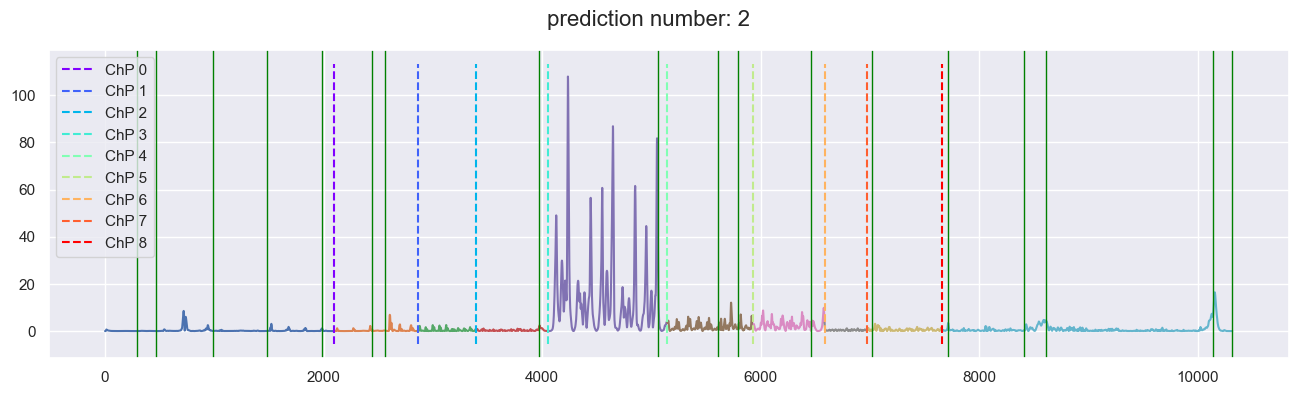

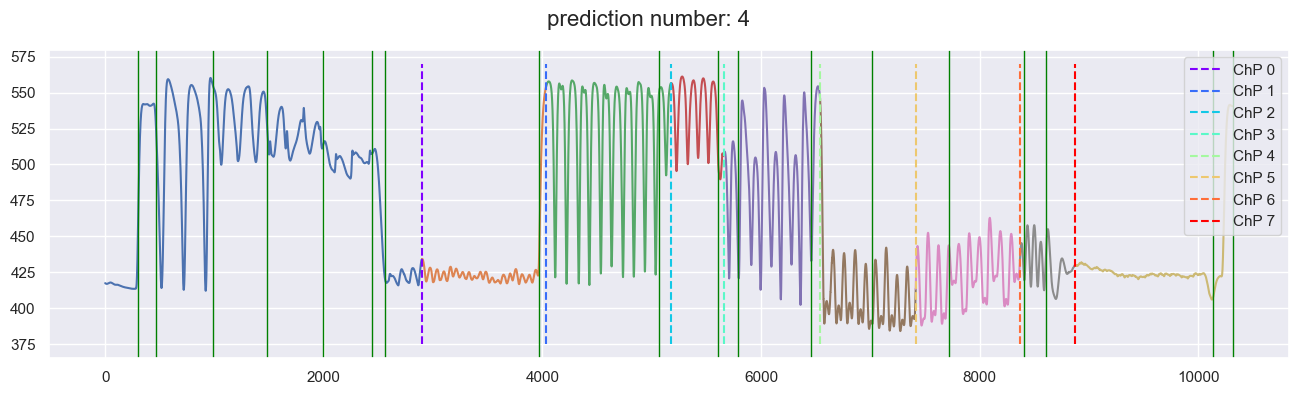

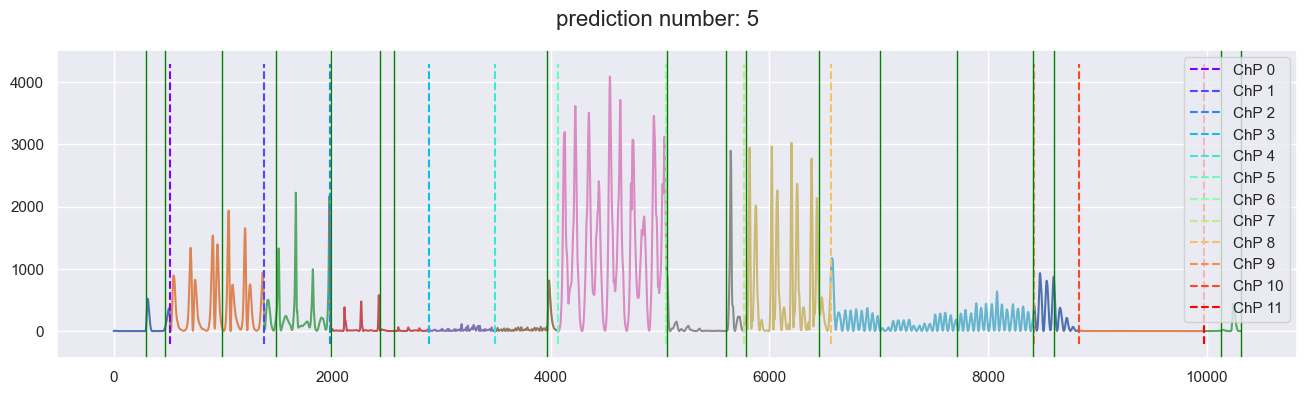

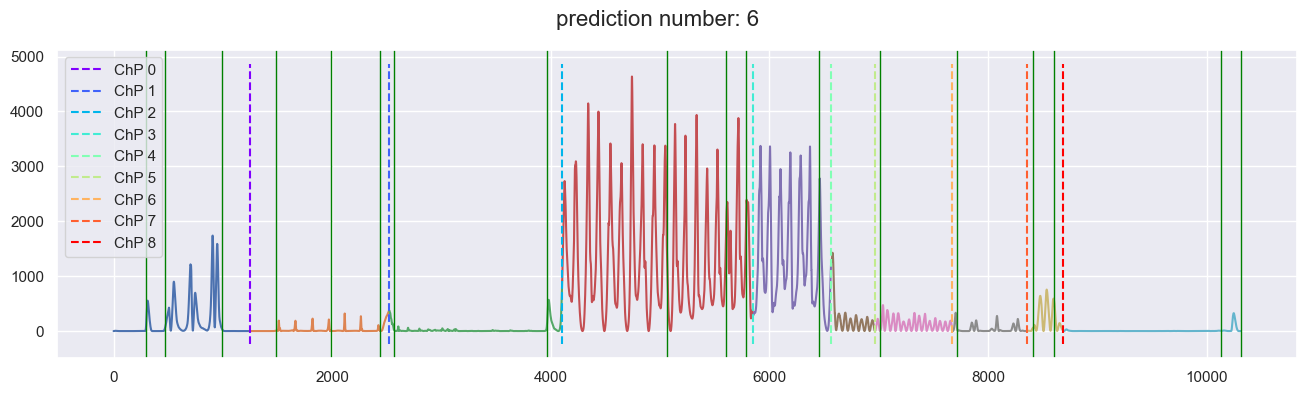

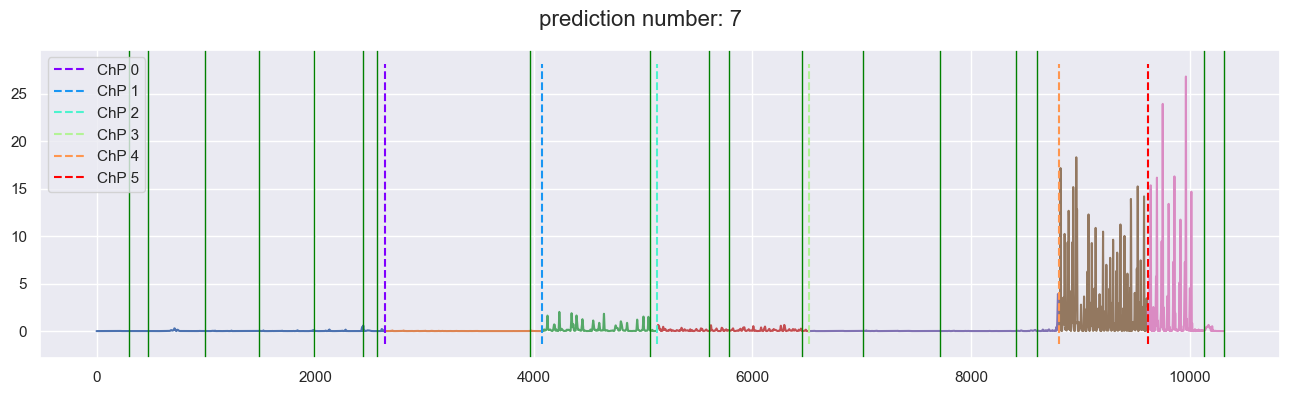

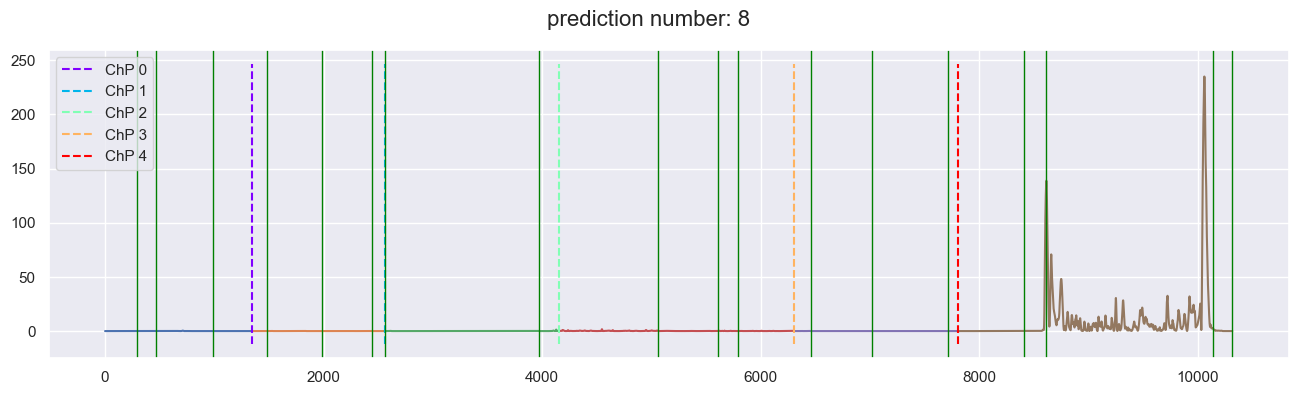

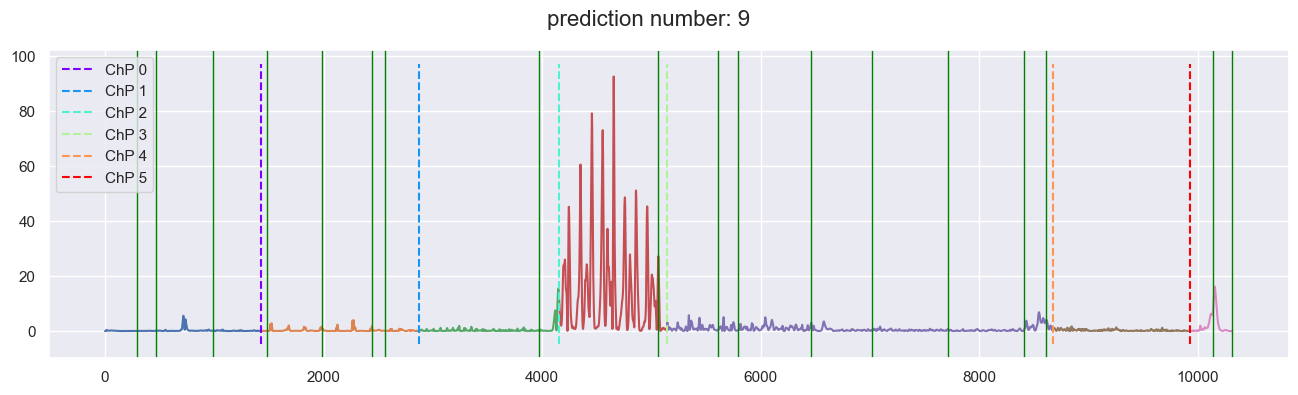

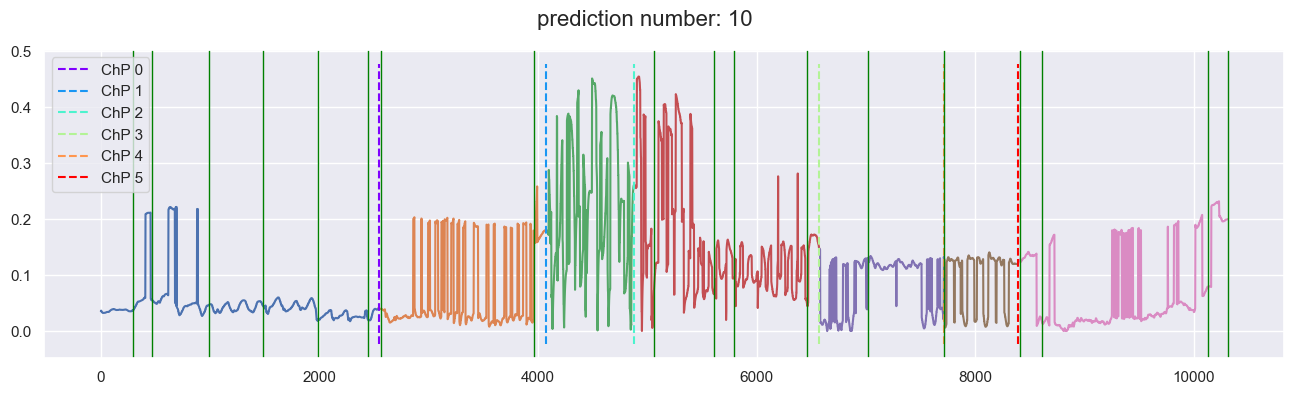

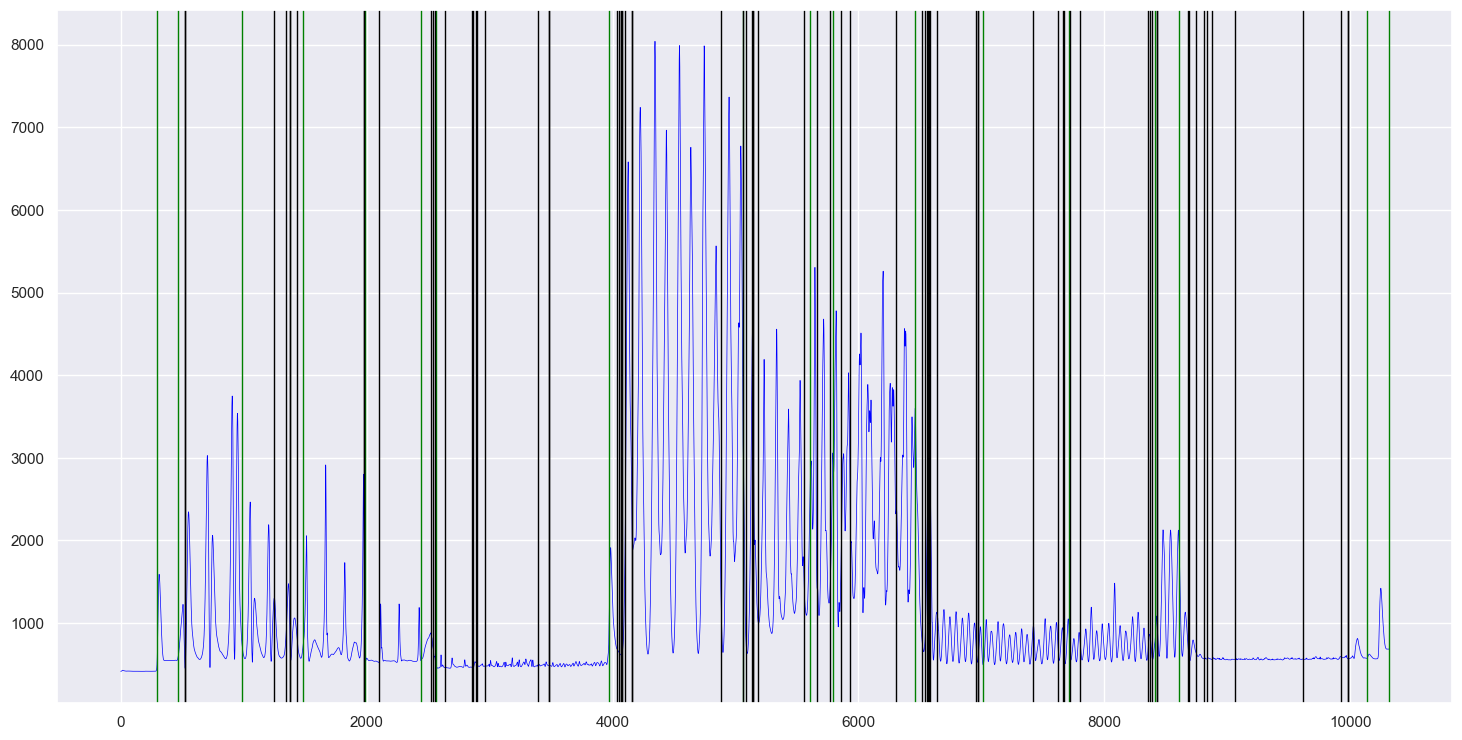

In [37]:
# CLASP with known number of cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,clasp=GetClasp(df,gt,1)
    PlotResult(df,gt,cp)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp)

In [ ]:
# CLASP without knowing cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,clasp=GetClasp(df,gt,0)
    PlotResult(df,gt,cp)
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp)

In [ ]:
# BINSEG with known number of cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp=GetBinseg(df,gt,1)
    PlotResult(df,gt,cp)
    Evaluate()

In [ ]:
# BINSEG without knowing cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp=GetBinseg(df,gt,0)
    PlotResult(df,gt,cp)
    Evaluate()

In [ ]:
# WINDOWSLIDE with known number of cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp=GetWindowSlide(df,gt,1)
    PlotResult(df,gt,cp)
    Evaluate()

In [ ]:
# WINDOWSLIDE without knowing cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp=GetWindowSlide(df,gt,0)
    PlotResult(df,gt,cp)
    Evaluate()